In [ ]:
"""
error log
ValueError: Error when checking target: expected conv2d_22 to have shape (61, 61, 3) but got array with shape (64, 64, 3)
output of layer is the first and the target is 64*64*3, need to match output
"""

In [27]:
import os
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" for CPU
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from os import listdir

In [28]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17115827907896787733
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13895692092474031332
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


In [29]:
import sys
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/FA2018/tutorials/ferienakademie2018-accelerating-physics-with-deep-learning/')
from functions import *

In [30]:
#forces CPU usage
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [31]:
os.getcwd()

'C:\\Users\\pkicsiny\\Desktop\\FA2018\\tutorials\\ferienakademie2018-accelerating-physics-with-deep-learning'

In [32]:
dataDir = os.getcwd() + '/data/trainSmallFA'
files = listdir(dataDir)
files[0:5]

['sm_goe503_1050_57.npz',
 'sm_goe503_1079_209.npz',
 'sm_goe503_1093_355.npz',
 'sm_goe503_1110_304.npz',
 'sm_goe503_1152_78.npz']

In [33]:
totalLength = len(files)

In [34]:
#array of inputs and outputs (predictions of the network)
inputs = np.empty((totalLength,3,64,64))
targets = np.empty_like(inputs)

In [35]:
np.shape(inputs) == np.shape(targets)

True

### Data prerpocessing

In [36]:
c = 1
for i, file in enumerate(files):
    npfile = np.load(dataDir +'/' + file)
    #a file contains 6 images: 3 for input p, vx, vy and output (ground truth) 
    d = npfile['a']
    inputs[i]  = d[0:3]   # inx, iny, mask 
    targets[i] = d[3:6]   # p, velx, vely
    if c:
        print('Shape of input-target array:',np.shape(targets))
        print('Shape of an element of input + output:',np.shape(d))
        # splits input file content of 6 channels to 3-3
        c = 0

Shape of input-target array: (751, 3, 64, 64)
Shape of an element of input + output: (6, 64, 64)


In [37]:
print('Input maxes:',inputs[:,0,:,:].max(), inputs[:,1,:,:].max(), inputs[:,2,:,:].max())
print('Input mins:',inputs[:,0,:,:].min(), inputs[:,1,:,:].min(), inputs[:,2,:,:].min())
print('Target maxes:',targets[:,0,:,:].max(), targets[:,1,:,:].max(), targets[:,2,:,:].max())
print('Target mins:',targets[:,0,:,:].min(), targets[:,1,:,:].min(), targets[:,2,:,:].min())

Input maxes: 98.70918772289284 36.22861719358889 1.0
Input mins: 0.0 0.0 0.0
Target maxes: 4321.8 171.772 140.251
Target mins: -13757.3 -71.886 -58.4272


In [38]:
normalized_inputs, normalized_targets, vxmax, vymax = normalize_data(inputs,targets,norm = 1)

In [39]:
print('Normalized input maxes:',normalized_inputs[:,0,:,:].max(), normalized_inputs[:,1,:,:].max(), normalized_inputs[:,2,:,:].max())
print('Normalized input mins:',normalized_inputs[:,0,:,:].min(), normalized_inputs[:,1,:,:].min(), normalized_inputs[:,2,:,:].min())
print('Normalized target maxes:',normalized_targets[:,0,:,:].max(), normalized_targets[:,1,:,:].max(), normalized_targets[:,2,:,:].max())
print('Normalized target mins:',normalized_targets[:,0,:,:].min(), normalized_targets[:,1,:,:].min(), normalized_targets[:,2,:,:].min())

Normalized input maxes: 98.70918772289284 36.22861719358889 1.0
Normalized input mins: 0.0 0.0 0.0
Normalized target maxes: 0.5181714179504846 1.739651600742902 1.7284380207634795
Normalized target mins: -1.957152811908768 -0.729521000704373 -0.7706419276952202


### Split datasets

In [40]:
#read test dataset
testDir = os.getcwd() + '/data/testDataSetFinal'
testFiles = listdir(testDir)

In [41]:
test_inputs = []
test_targets = []
for i, file in enumerate(testFiles):
    npfile = np.load(testDir +'/' + file)
    #a file contains 6 images: 3 for input p, vx, vy and output (ground truth) 
    d = npfile['a']
    test_inputs.append(d[0:3])   # inx, iny, mask 
    test_targets.append(d[3:6])   # p, velx, vely
test_inputs = np.asarray(test_inputs)
test_targets = np.asarray(test_targets)


In [42]:
n_test_inputs, n_test_targets, n_vxmax, n_vymax = normalize_data(test_inputs,test_targets,norm = 1)

In [44]:
train_val_inputs = normalized_inputs
train_val_targets = normalized_targets

In [45]:
#train_val_inputs,train_val_targets,test_inputs,test_targets = randsplit(normalized_inputs,normalized_targets,frac=.9)

In [46]:
#training data
train_val_inputs  = train_val_inputs.transpose(0,2,3,1)
train_val_targets = train_val_targets.transpose(0,2,3,1)

#test dataset
n_test_inputs  = n_test_inputs.transpose(0,2,3,1)
n_test_targets = n_test_targets.transpose(0,2,3,1)

print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(n_test_inputs),np.shape(n_test_targets))

Training data shape: (751, 64, 64, 3) (751, 64, 64, 3)
Test data shape: (10, 64, 64, 3) (10, 64, 64, 3)


In [47]:
#flattening if last layer is fcl
#train_val_targets = np.reshape(train_val_targets,(len(train_val_targets),-1))
#n_test_targets = np.reshape(n_test_targets,(len(n_test_targets),-1))

In [48]:
print('Training data shape:',np.shape(train_val_inputs),np.shape(train_val_targets))
print('Test data shape:',np.shape(n_test_inputs),np.shape(n_test_targets))

Training data shape: (751, 64, 64, 3) (751, 64, 64, 3)
Test data shape: (10, 64, 64, 3) (10, 64, 64, 3)


### Network architecture

In [49]:
#convolution filters
f1 = 8
f2 = 3
#kernel size
k1 = 4
k2 = 2
#stride
s1 = 4
s2 = 2
#padding
p1 = 0
p2 = 0

Toy network

In [50]:
model=keras.Sequential()

conv1 = keras.layers.Conv2D(input_shape = (64,64,3),
                              filters = f1,
                              kernel_size=(k1,k1),
                              strides=(s1, s1),
                              padding='valid',
                              data_format = "channels_last",
                             activation = 'tanh')
conv2 = keras.layers.Conv2D(input_shape = (16,16,3),
                              filters = f2,
                              kernel_size=(k2,k2),
                              strides=(s2, s2),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
conv3 = keras.layers.Conv2D(input_shape = (8,8,3),
                              filters = 3,
                              kernel_size=(8,8),
                              strides=(1, 1),
                              padding='same',
                              data_format = "channels_last",
                              activation = 'tanh')
upsample1 = keras.layers.UpSampling2D(size=(4, 4), data_format="channels_last",input_shape = (8,8,3))
dense1 = keras.layers.Dense(64*64*3,activation='tanh')
#architeccture
model.add(conv1)
model.add(conv2)
model.add(conv3)
model.add(upsample1)
model.add(keras.layers.Flatten())
model.add(dense1)

U-net

In [96]:
model2=keras.Sequential()

init = keras.layers.Input(shape=(64,64,3))
ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
Lr1 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown1)
#64
ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
Lr2 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown2)
#32
ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
Lr3 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown3)
#16
ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
Lr4 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown4)
#8
ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
Lr5 = keras.layers.LeakyReLU(alpha=0.0)(ConvDown5)
#4

UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
#8
merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
Lr6 = keras.layers.LeakyReLU(alpha=0.0)(Conv1)
#8
UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
#16
merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
Lr7  = keras.layers.LeakyReLU(alpha=0.0)(Conv2)
#16
UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

#32
Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
Lr8  = keras.layers.LeakyReLU(alpha=0.0)(Conv3)

UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
#64
Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'relu')(UpSamp4)

Conv5   = keras.layers.Conv2D(filters=3,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'elu')(Conv4)

model2 = keras.models.Model(inputs=init, outputs=Conv5)

### Training

In [97]:
#train the model
model2.compile(optimizer=tf.train.AdamOptimizer(learning_rate = 0.0001),loss='mean_squared_error', metrics=['accuracy',relative_error_tensor]) 
model2.fit(train_val_inputs,
          train_val_targets,
          batch_size = 50,
          epochs=50,
          validation_split = 0.1,
          shuffle = True)

Tensor("metrics_3/relative_error_tensor/truediv:0", shape=(), dtype=float32)
Tensor("conv2d_41_target:0", shape=(?, ?, ?, ?), dtype=float32)
Train on 675 samples, validate on 76 samples
Epoch 1/50
675/675 [==============================] - 4s 6ms/step - loss: 0.6449 - acc: 0.3694 - relative_error_tensor: 1.4320 - val_loss: 0.4509 - val_acc: 0.7476 - val_relative_error_tensor: 1.2585
Epoch 2/50
675/675 [==============================] - 3s 4ms/step - loss: 0.2117 - acc: 0.8397 - relative_error_tensor: 0.8306 - val_loss: 0.3216 - val_acc: 0.8932 - val_relative_error_tensor: 1.0601
Epoch 3/50
675/675 [==============================] - 3s 4ms/step - loss: 0.1614 - acc: 0.8969 - relative_error_tensor: 0.7230 - val_loss: 0.2485 - val_acc: 0.8996 - val_relative_error_tensor: 0.9209
Epoch 4/50
675/675 [==============================] - 3s 4ms/step - loss: 0.1401 - acc: 0.9000 - relative_error_tensor: 0.6701 - val_loss: 0.2035 - val_acc: 0.9077 - val_relative_error_tensor: 0.8438
Epoch 5/50
675

KeyboardInterrupt: 

### Plot loss and network info

In [74]:
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 64, 64, 8)    104         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 64, 64, 8)    0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 32, 32, 16)   528         leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [75]:
hist = model2.history

In [76]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'val_relative_error_tensor', 'loss', 'acc', 'relative_error_tensor'])

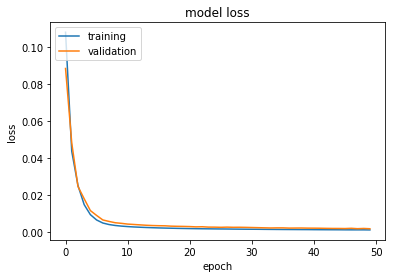

In [77]:
plot_trainingcurves(hist)

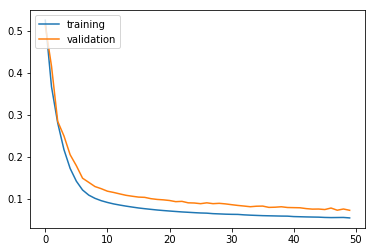

In [78]:
plt.plot(hist.history['relative_error_tensor'],)
plt.plot(hist.history['val_relative_error_tensor'])
plt.legend(['training', 'validation'], loc='upper left')

### Predicting

In [79]:
#test
predictions = model2.predict(n_test_inputs, batch_size=1)
truth     = n_test_targets

predictions = np.reshape(predictions, (len(n_test_inputs),64,64,3))
truth       = np.reshape(truth, (len(n_test_targets),64,64,3))

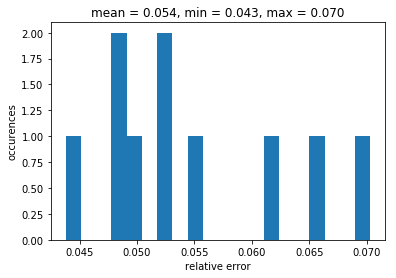

In [80]:
error_distribution(truth,predictions)

In [81]:
args = arg_getter(truth,predictions)

0


### Plot results

0


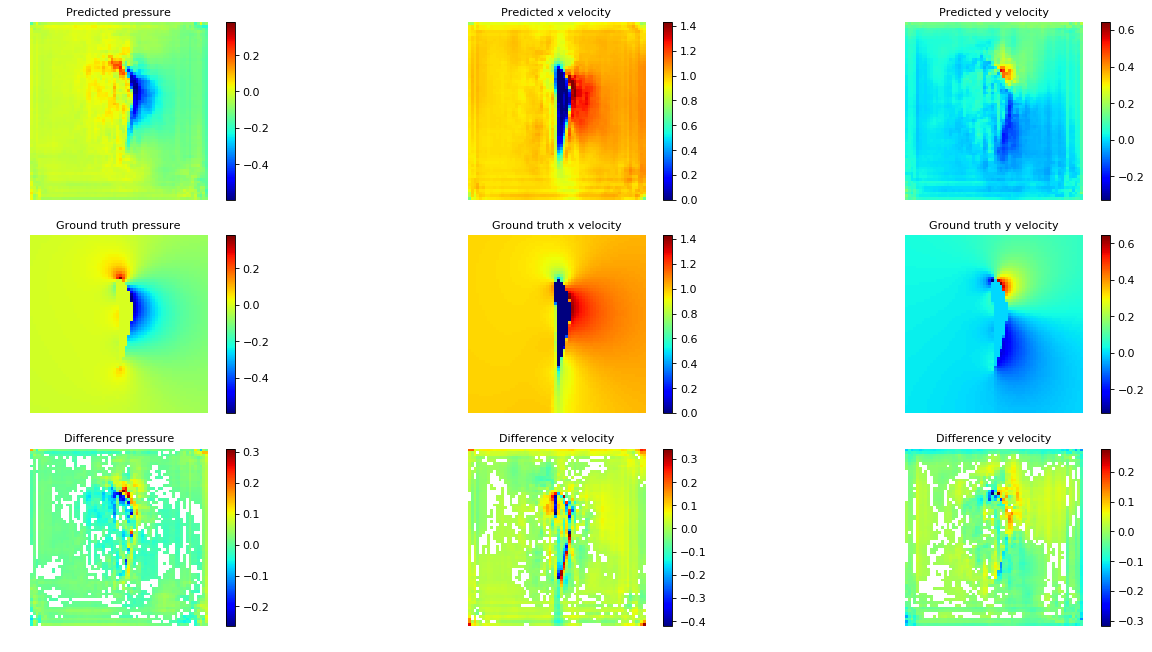

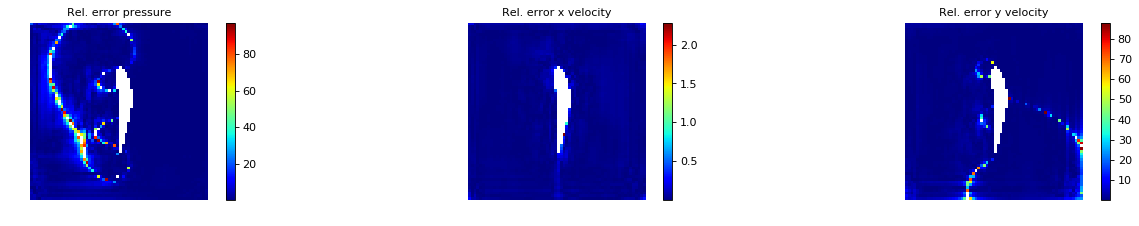

In [99]:
plotter(predictions,truth,index = args[-1])

In [138]:
def get_mean_img(reference,output):
    mean_ref = reference.mean()
    mean_output = output.mean()
    rel_err = []
    #[rel_err.append(relative_error(mean_ref[:,:,ch], mean_output[:,:,ch])) for ch in range(0,3)]
    #ref_mean_truth = np.mean(np.abs(mean_ref))
    #ref_mean_pred = np.mean(np.abs(mean_output))
    return mean_ref, mean_output#, rel_err, ref_mean_truth, ref_mean_pred

In [139]:
pred, target = denormalize_data(predictions, truth, n_vxmax,n_vymax)

In [165]:
mean_ref, mean_output = get_mean_img(test_inputs.transpose(0,2,3,1),test_targets.transpose(0,2,3,1))

In [180]:
test_inputs.mean()

20.686136044049398

In [181]:
test_targets.mean()

-83.21094136105935

In [166]:
mean_output

-83.21094136105935

In [167]:
mean_ref

20.686136044049398

In [168]:
np.asarray(rel_err).mean()

0.06945345419659647

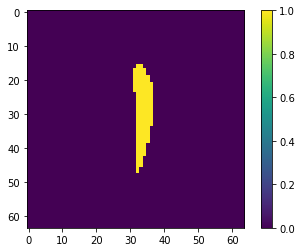

In [173]:
plt.imshow(test_inputs.transpose(0,2,3,1)[0,:,:,2])
plt.colorbar()